# Variational Auto-Encoders - VAEs

## Introduction and theoretical background

**Variational Auto-Encoders (VAEs)** are an inference paradigm invented by D. P. Kingma and M. Welling with the goal of performing efficient approximate inference and learning with models characterized by continuous latent variables and/or parameters that have intractable posterior distributions. In order to address VAEs, it is worth starting from the basic idea of Variational Bayes, i.e. approximating the target posterior distribution with a distribution

$$
q(\bm{z}|\bm{x},\bm{\phi}), \tag{1}
$$

belonging to a certain family of functions $Q$, where $\bm{z}$ and $\bm{\phi}$ are the the latent variables and the function parameters respectively. If 

$$
p(\bm{x}, \bm{z}|\bm{\theta}) \tag{2}
$$

represents the joint probability distribution of our visible $\bm{x}$ and hidden $\bm{z}$ units, given the model parameters $\bm{\theta}$, the marginal probability distribution of $\bm{x}$ satisfies

$$
\log p(\bm{x}|\bm{\theta}) = D_{KL}(q(\bm{z}|\bm{x},\bm{\phi})||p(\bm{z}|\bm{x}, \bm{\theta})) + \mathcal{L}(\bm{\theta}, \bm{\phi}; \bm{x}) \tag{3}
$$

with 

$$
\mathcal{L}(\bm{\theta}, \bm{\phi}; \bm{x}) = \mathbb{E}_{q_{\phi}} \left[\log p(\bm{x}, \bm{z}|\bm{\theta}) - \log q(\bm{z}|\bm{x},\bm{\phi})\right] \tag{4}
$$


being the **variational lower bound** of the marginal likelihood. Our goal is finding $q$ such that the Kullback-Leibler divergence term is minimum and this minimization problem is equivalent to the maximization of the variational lower bound $\mathcal{L}$. The standard approach to this problem is the Mean Field (MF) ansatz, which consists in assuming a factorized form of $q$ over a subset of latent variables:

$$
q(\bm{z}|\bm{x},\bm{\phi}) = \prod_i q(\bm{z_i}|\bm{x},\bm{\phi}). \tag{5}
$$

The problem is that MF approach involves the calculations of integrals depending on $q_i$ that in many cases are **intractable**, thus limiting the range if its applicability. Starting from these observations, the article focuses on finding a solution to the problems that arise consequently:
- efficient approximate estimation for the parameters $\bm{\theta}$
- efficient approximate estimation of $p(\bm{z}|\bm{x}, \bm{\theta})$
- efficient approximate esitmation of $p(\bm{x}|\bm{\theta})$.

Then, assuming that the MF approach is not doable, in our new scenario:
- $q(\bm{z}|\bm{x},\bm{\phi})$ is not assumed to be factorized anymore and acts as an **encoder** since starting from a datapoint $\bm{x}$ it provides a distribution over the latent space variables
- $p(\bm{x}|\bm{z},\bm{\theta})$ acts as a **decoder** since starting from an encoded datapoint $\bm{z}$ living in the latent space it provides a distribution over the possible values of $\bm{x}$ that may correspond to it.

Of course, we are left with the problem of learning the parameters that define our probabilistic encoder and decoder. To deal with it, it is useful to rewrite the variational lower bound $(4)$ as 

$$
\mathcal{L}(\bm{\theta}, \bm{\phi}; \bm{x}^{(i)}) = -D_{KL}(q(\bm{z}|\bm{x}^{(i)},\bm{\phi})||p(\bm{z}|\bm{\theta})) + \mathbb{E}_{q_{\phi}} \left[\log p(\bm{x}^{(i)}|\bm{z}, \bm{\theta})\right] \tag{6}
$$

and thus our problem becomes the following **optimization**:

$$
\hat{\bm{\phi}}, \hat{\bm{\theta}} = \argmax_{\bm{\phi}, \bm{\theta}} \mathcal{L}(\bm{\theta}, \bm{\phi}; \bm{x}). \tag{7}
$$

In order to compute the expectation value, the article introduces the **reparametrization trick** to avoid estimates having a large variance that would undermine the optimization. This trick consists in setting

$$
\tilde{\mathcal{L}}^B(\bm{\theta}, \bm{\phi}; \bm{x}^{(i)}) = -D_{KL}(q(\bm{z}|\bm{x}^{(i)},\bm{\phi})||p(\bm{z}|\bm{\theta})) + \frac{1}{L} \sum_{l=1}^L \log p(\bm{x}^{(i)}|\bm{z_l}^{(i,l)}, \bm{\theta}) \tag{8}
$$

where $\bm{z}_l = g_{\bm{\phi}}(\bm{\epsilon_l}, \bm{x})$ is a deterministic differentiable transformation and $\bm{\epsilon}_l \sim p(\bm{\epsilon})$ is a random noise vector chosen such that it ensures $\bm{z}_l \sim q(\bm{z}|\bm{x},\bm{\phi})$. The estimator of the variational lower bound provided by Eq. $(8)$ is called **Stochastic Gradient Variational Bayes** (SGVB) estimator.

## VAE Implementation

The main focus of the article is showing the implementation of the aforementioned architecture in which both **the encoder and the decoder consist in neural networks**, more precisely Multi-Layer Perceptron (MLP) blocks, i.e. fully-connected blocks with only one hidden layer between input and output. This allows optimizing the lower bound $(8)$ by exploiting the most common gradient ascent algorithms. The implementation also involves:
1. setting the prior as a multivariate normal with zero mean and an identity as covariance matrix,
$$
p(\bm{z}|\bm{\theta}) = \mathcal{N}(\bm{0}, \bm{I}) \tag{9}
$$
2. assuming that the approximate posterior is Gaussian with diagional identity matrix
$$
q(\bm{z}|\bm{x}^{(i)},\bm{\phi}) \equiv \mathcal{N}(\bm{z}|\bm{\mu}_\phi(\bm{x}^{(i)}), diag(\bm{\sigma}^2_\phi(\bm{x}^{(i)}))) \tag{10}
$$
3. assuming that the conditional likelihood is also Gaussian with diagonal identity matrix
$$
p(\bm{x}^{(i)}|\bm{z}^{(i,l)}, \bm{\theta}) \equiv \mathcal{N}(\bm{x}^{(i)}|\bm{\mu}_\theta(\bm{z}^{(i,l)}), diag(\bm{\sigma}^2_\theta(\bm{z}^{(i,l)}))) \tag{11}
$$

In this way, the output of the encoder and of the decoder will be $\bm{\mu}_\phi(\bm{x}), \bm{\sigma}^2_\phi(\bm{x})$ and $\bm{\mu}_\theta(\bm{z_l}), \bm{\sigma}^2_\theta(\bm{z}_l)$ respectively. Moreover, thanks to these choices for the distributions, we have that the Kullback-Leibler divergence term assumes an analytical form, allowing us to obtain a **convenient form of the variational lower** bound that we can directly exploit inside the code of a **training loop**:

$$
\tilde{\mathcal{L}}^B(\bm{\theta}, \bm{\phi}; \bm{x}^{(i)}) = \frac{1}{2} \sum_{j=1}^J \left(1 + \log((\bm{\sigma}^{(i)}_\phi)^2_j) - (\bm{\mu}^{(i)}_\phi)_j^2 - (\bm{\sigma}^{(i)}_\phi)_j^2\right) + \frac{1}{L} \sum_{l=1}^L \log \mathcal{N}(\bm{x}^{(i)}|\bm{\mu}_\theta(\bm{z}^{(i,l)}), diag(\bm{\sigma}^2_\theta(\bm{z}^{(i,l)}))) \tag{12}
$$

with

$$
\bm{z}^{(i,l)} = \bm{\mu}^{(i)}_\phi + \bm{\sigma}^{(i)}_\phi \odot \bm{\epsilon^{(l)}}, \qquad \epsilon^{(l)} \sim \mathcal{N}(\bm{0}, \bm{I})
$$

and 

$$
\begin{align}
\bm{\mu} &=& \bm{W}_4 \bm{h} + \bm{b}_4 \nonumber \\
\log \bm{\sigma}^2 &=& \bm{W}_5 \bm{h} + \bm{b}_5 \nonumber \\
h &=& \text{ReLU}(\bm{W}_3 \bm{x} + \bm{b}_3) \nonumber \tag{13}
\end{align}
$$

In particular, the set of equations $(13)$ holds both for the encoder and decoder parameters, provided that $\bm{x}$ is swapped with $\bm{z}$ in the equation for $\bm{h}$.

## Presentation of the code 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.optim import Adam

#### Configuration of the model 

In [2]:
dataset_path = '~/datasets'
cuda = False 
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 100
epochs = 100
x_dim  = 784
hidden_dim = 500
latent_dim = 2
lr = 1e-3

#### Data importation and data loader

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader 
transform = transforms.ToTensor()

train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

#### Encoder 

In [4]:
class Encoder(nn.Module):
    def __init__(self,input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.in_2hid = nn.Linear(input_dim, hidden_dim)
        self.hid_2mu = nn.Linear(hidden_dim, latent_dim)
        self.hid_2var = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x:torch.Tensor):
        h = self.LeakyReLU(self.in_2hid(x))
        mu_lat = self.hid_2mu(h)
        log_var_lat = self.hid_2var(h)

        return mu_lat, log_var_lat

#### Decoder

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.lat_2hid = nn.Linear(latent_dim, hidden_dim)
        self.hid_2mu = nn.Linear(hidden_dim, output_dim)
        self.hid_2var = nn.Linear (hidden_dim, output_dim)

        # Activating function 
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, z:torch.Tensor):
        h = self.LeakyReLU(self.lat_2hid(z))
        mu_recon = self.hid_2mu(h)
        log_var_recon = self.hid_2var(h)
        std_recon = torch.exp(0.5 * log_var_recon)
        
        mu_recon = torch.sigmoid(mu_recon)
        std_recon = torch.sigmoid(std_recon)

        return mu_recon, std_recon


#### Model Definition

In [6]:
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE,self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self,mu_lat,sdt_lat):
        epsilon = torch.rand_like(sdt_lat).to(DEVICE)
        z = mu_lat + sdt_lat*epsilon

        return z

    def forward(self, x:torch.Tensor):
        mu_lat, log_var_lat = self.Encoder(x)
        z = self.reparameterization(mu_lat, torch.exp(0.5*log_var_lat))
        mu_recon, std_recon = self.Decoder(z)

        return mu_lat, log_var_lat, mu_recon, std_recon

#### Model Instantiation

In [7]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)
vae = VAE(Encoder=encoder, Decoder=decoder).to(DEVICE)

#### Definition of the ELBO


In [8]:
def loss_fn(x,mu_lat, log_var_lat, mu_recon, std_recon):

    recon_normal = torch.distributions.Normal(mu_recon, std_recon)
    recon_loss = recon_normal.log_prob(x).sum()
    KLD_loss = 0.5 * torch.sum(1 + log_var_lat - mu_lat.pow(2) - log_var_lat.exp())

    return - (KLD_loss + recon_loss)

optimizer = Adam(vae.parameters(), lr=lr)

#### Training loop

In [ ]:
vae.train() 

for epoch in range(epochs):
    epoch_avg_loss = 0
    
    print(f"_________________Epoch: {epoch+1}______________")
    for batch_idx, (x, _) in enumerate(tqdm(train_loader)): 
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        optimizer.zero_grad()
        mu_lat, log_var_lat, mu_recon, sdt_recon = vae(x)
        loss = loss_fn(x, mu_lat, log_var_lat, mu_recon, sdt_recon)
        epoch_avg_loss += loss
        loss.backward()
        optimizer.step()
        
    epoch_avg_loss /= len(train_loader) 



## Test of the model 

#### Image reconstruction 

Text(0.5, 1.0, 'Reconstructed')

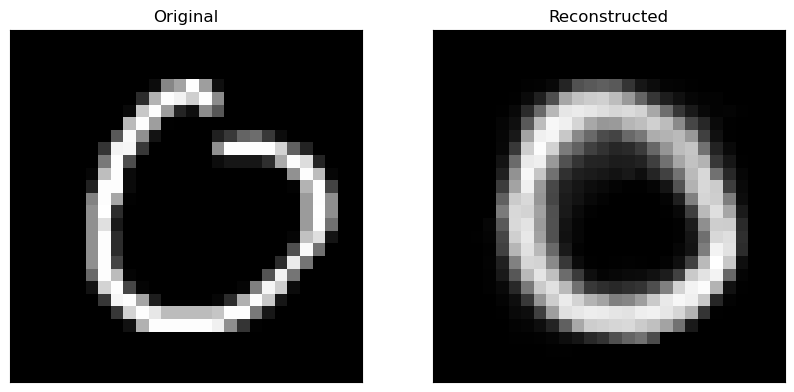

In [15]:
torch.manual_seed(9112001)
vae.eval()

with torch.no_grad():
    for batch_idx, (x, _)  in enumerate(test_loader):
        
        x = x.view(x.size(0), -1)
        x = x.to(DEVICE)
        _, _, x_hat, _ = vae(x)
        x_hat = x_hat.view(-1,28, 28)  
        break

idx = 0

fig, ax = plt.subplots(1, 2, figsize = (10,15))
ax[0].set_xticks([])
ax[0].set_yticks([])
x = x.view(x.size(0), 28, 28)
ax[0].imshow(x[idx].cpu(), cmap= 'gray')
ax[0].set_title('Original')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(x_hat[idx].cpu(), cmap= 'gray')
ax[1].set_title('Reconstructed')

#### Plot of the latent space

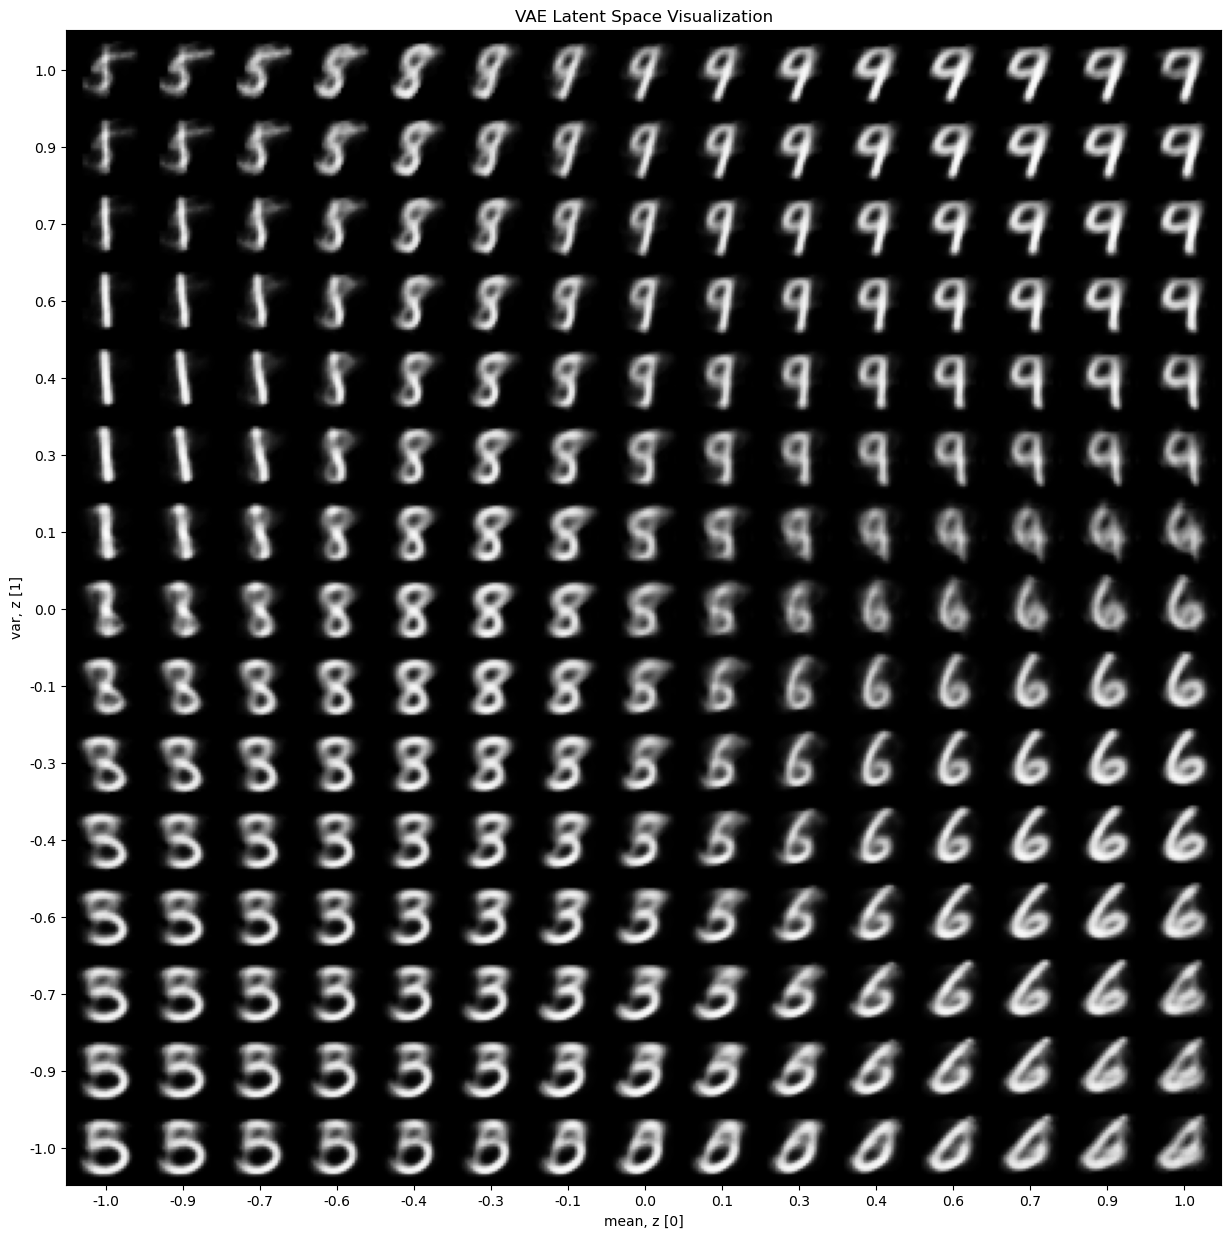

In [11]:
vae.eval()

def plot_latent_space(model, x_range=[-1,1], y_range=[-1, 1], n=15, h=28, w= 28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((h * n, w * n))

    # construct a grid 
    grid_x = np.linspace(x_range[0], x_range[1], n)
    grid_y = np.linspace(y_range[0], y_range[1], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(DEVICE)
            x_decoded = model.Decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(h, w)
            figure[i * h : (i + 1) * h, j * w : (j + 1) * w] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range_x = w // 2
    end_range_x = n * w + start_range_x
    start_range_y = h // 2
    end_range_y = n * h + start_range_y
    pixel_range_x = np.arange(start_range_x, end_range_x, w)
    pixel_range_y = np.arange(start_range_y, end_range_y, h)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range_x, sample_range_x)
    plt.yticks(pixel_range_y, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)